In [20]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

import os
import glob
import re
from scanf import scanf
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from matplotlib import cm

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf

# %matplotlib notebook

rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

In [21]:
def read_data_psi(psi_dir, tcenter):
    ecoli_U_list = []
    ecoli_norm_list = []
    ecoli_center_list = []
    ecoli_nodes_list = []
    ecoli_u_list = []
    ecoli_f_list = []
    ecoli_lateral_norm_list = []
    norm_phi_list = []
    norm_psi_list = []
    norm_theta_list = []
    file_handle = os.path.basename(psi_dir)
    mat_names = natsort.natsorted(glob.glob('%s/%s_*.mat' % (psi_dir, file_handle)))
    for mati in mat_names:
        mat_contents = loadmat(mati)
        ecoli_U = mat_contents['ecoli_U'].flatten()
        ecoli_norm = mat_contents['ecoli_norm'].flatten()
        ecoli_center = mat_contents['ecoli_center'].flatten()
        ecoli_nodes = mat_contents['ecoli_nodes']
        ecoli_u = mat_contents['ecoli_u']
        ecoli_f = mat_contents['ecoli_f']
        planeShearRate = mat_contents['planeShearRate'].flatten()
        norm_phi = mat_contents['norm_phi'].flatten()
        norm_psi = mat_contents['norm_psi'].flatten()
        norm_theta = mat_contents['norm_theta'].flatten()
        ecoli_U_list.append(ecoli_U)
        ecoli_norm_list.append(ecoli_norm)
        ecoli_center_list.append(ecoli_center)
        norm_phi_list.append(norm_phi)
        norm_psi_list.append(norm_psi)
        norm_theta_list.append(norm_theta)
        r0 = ecoli_nodes[-1] - ecoli_center
        n0 = np.dot(r0, ecoli_norm) * ecoli_norm / np.dot(ecoli_norm, ecoli_norm)
        t0 = r0 - n0
        ecoli_lateral_norm_list.append(t0 / np.linalg.norm(t0))

    ecoli_U = np.vstack(ecoli_U_list)
    ecoli_norm = np.vstack(ecoli_norm_list)
    ecoli_center = np.vstack(ecoli_center_list)
    ecoli_lateral_norm = np.vstack(ecoli_lateral_norm_list)
    norm_phi = np.hstack(norm_phi_list)
    norm_psi = np.hstack(norm_psi_list)
    norm_theta = np.hstack(norm_theta_list)
    norm_tpp = np.vstack((norm_theta, norm_phi, norm_psi)).T

    # calculate velocity u000(t,x,y,z) that the location initially at (0, 0, 0): u000(0, 0, 0, 0)
    n_u000 = -np.linalg.norm(ecoli_center[0] - tcenter) * ecoli_norm
    ecoli_u000 = ecoli_U[:, :3] + np.cross(ecoli_U[:, 3:], n_u000)
    # calculate center center000(t,x,y,z) that at initially at (0, 0, 0): center000(0, 0, 0, 0)
    ecoli_center000 = ecoli_center + n_u000
    using_U = ecoli_U
    omega_norm = np.array([np.dot(t1, t2)*t2/np.dot(t2, t2) for t1, t2 in zip(using_U[:, 3:], ecoli_norm)])
    omega_tang = using_U[:, 3:] - omega_norm
    
    return ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, norm_tpp, \
           ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate, file_handle

'/home/zhangji/stokes_flow_master/head_Force/loop_table/hlxB01_tau1a/hlxB01_psi0.00'

ValueError: cannot reshape array of size 6622 into shape (80,80)

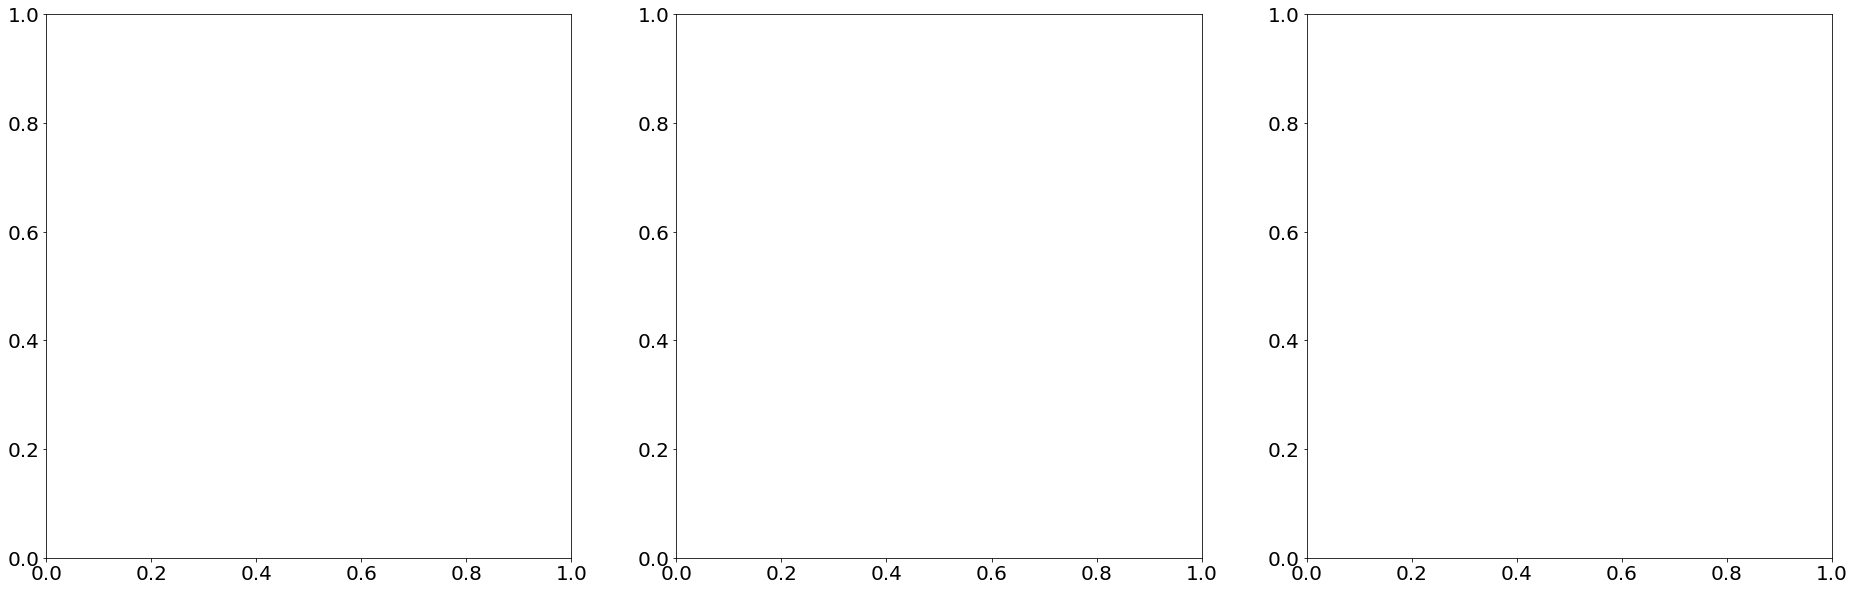

In [26]:
# %matplotlib notebook
%matplotlib inline

importlib.reload(spf)
job_dir = 'hlxB01_tau1a'
n_theat, n_phi = 80, 80
t_dir = os.path.join(PWD, job_dir)
psi_dir_list = natsort.natsorted([os.path.join(t_dir, o) for o in os.listdir(t_dir) 
                                  if os.path.isdir(os.path.join(t_dir, o))])
tcenter = np.zeros(3)

# for psi_dir in np.array(psi_dir_list)[[1, 2, 3, 4, 5, 8, 9]]:
for psi_dir in np.array(psi_dir_list):
    ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, norm_tpp, \
      ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate, file_handle \
      = read_data_psi(psi_dir, tcenter)

    fig = plt.figure(figsize=(32, 10))
    fig.patch.set_facecolor('white')
    ax0 = fig.add_subplot(1, 3, 1)
    ax1 = fig.add_subplot(1, 3, 2)
    ax2 = fig.add_subplot(1, 3, 3)
    for axi, omegai, zlabeli, (vmin, vmax) in zip((ax0, ax1, ax2), 
                                                omega_tang[1:, :].T, 
                                                ('omega0', 'omega1', 'omega2'), 
                                                ((-0.1, 0.1), (0, 1), (-0.5, 0.1))):
#                                                 ((None, None), (None, None), (None, None))):
        plt.sca(axi)
        ticks = np.linspace(vmin, vmax, 15)
        im = axi.contourf(norm_tpp[1:, 0].reshape((n_theat, n_phi))[::4, ::4], 
                          norm_tpp[1:, 1].reshape((n_theat, n_phi))[::4, ::4], 
                          omegai.reshape((n_theat, n_phi))[::4, ::4], ticks, 
                          cmap=cm.coolwarm)
        ticks = np.linspace(vmin, vmax, 5)
        fig.colorbar(im, ticks=ticks, ax=axi).ax.tick_params(labelsize=fontsize*0.8)
        ticks = np.linspace(vmin, vmax, 10)
        im = axi.contour(norm_tpp[1:, 0].reshape((n_theat, n_phi))[::4, ::4], 
                          norm_tpp[1:, 1].reshape((n_theat, n_phi))[::4, ::4], 
                          omegai.reshape((n_theat, n_phi))[::4, ::4], ticks, 
                          linewidths=fontsize*0.1, colors='k')
        plt.clabel(im, fmt='%4.2f', colors='k', fontsize=fontsize*0.8, inline=0, rightside_up=1)
#         axi.scatter(norm_tpp[1:, 0], norm_tpp[1:, 1])
#         ax0.plot(norm_tpp[:, 0], norm_tpp[:, 1], omega_jeffery[:, 1], 'o')
        axi.set_xlabel('norm_theta', size=fontsize)
        axi.set_ylabel('norm_phi', size=fontsize)
        axi.set_title('%s, %s' % (file_handle, zlabeli), size=fontsize*0.8)
        plt.xticks(fontsize=fontsize*0.8)
        plt.yticks(fontsize=fontsize*0.8)
    plt.tight_layout()

/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


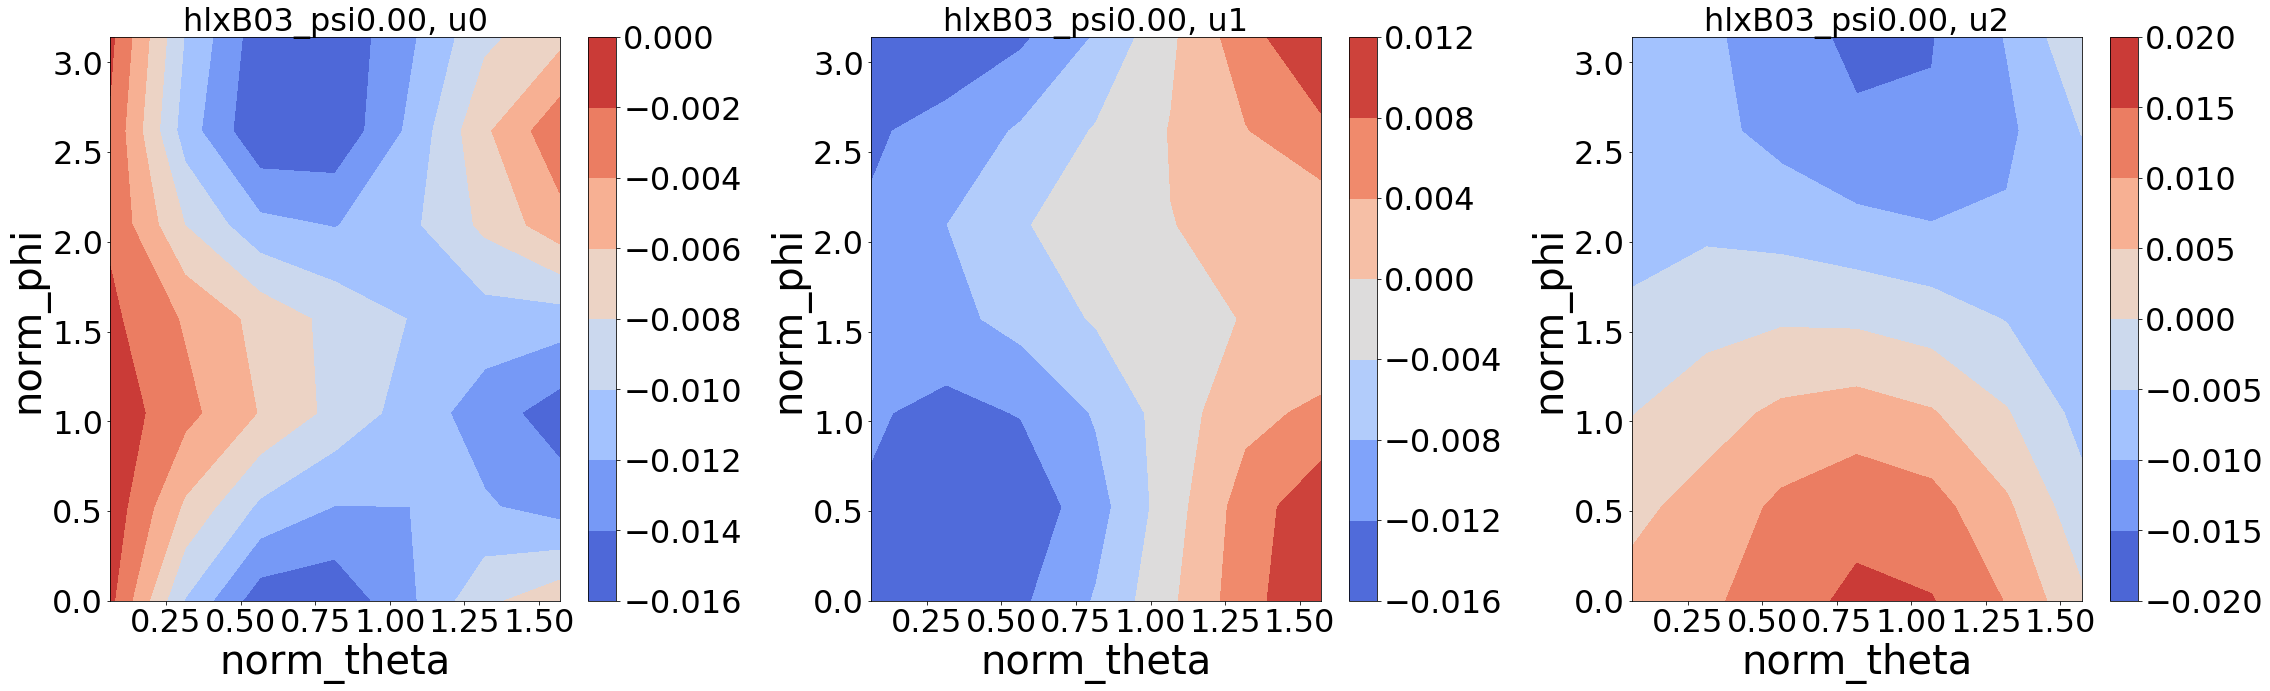

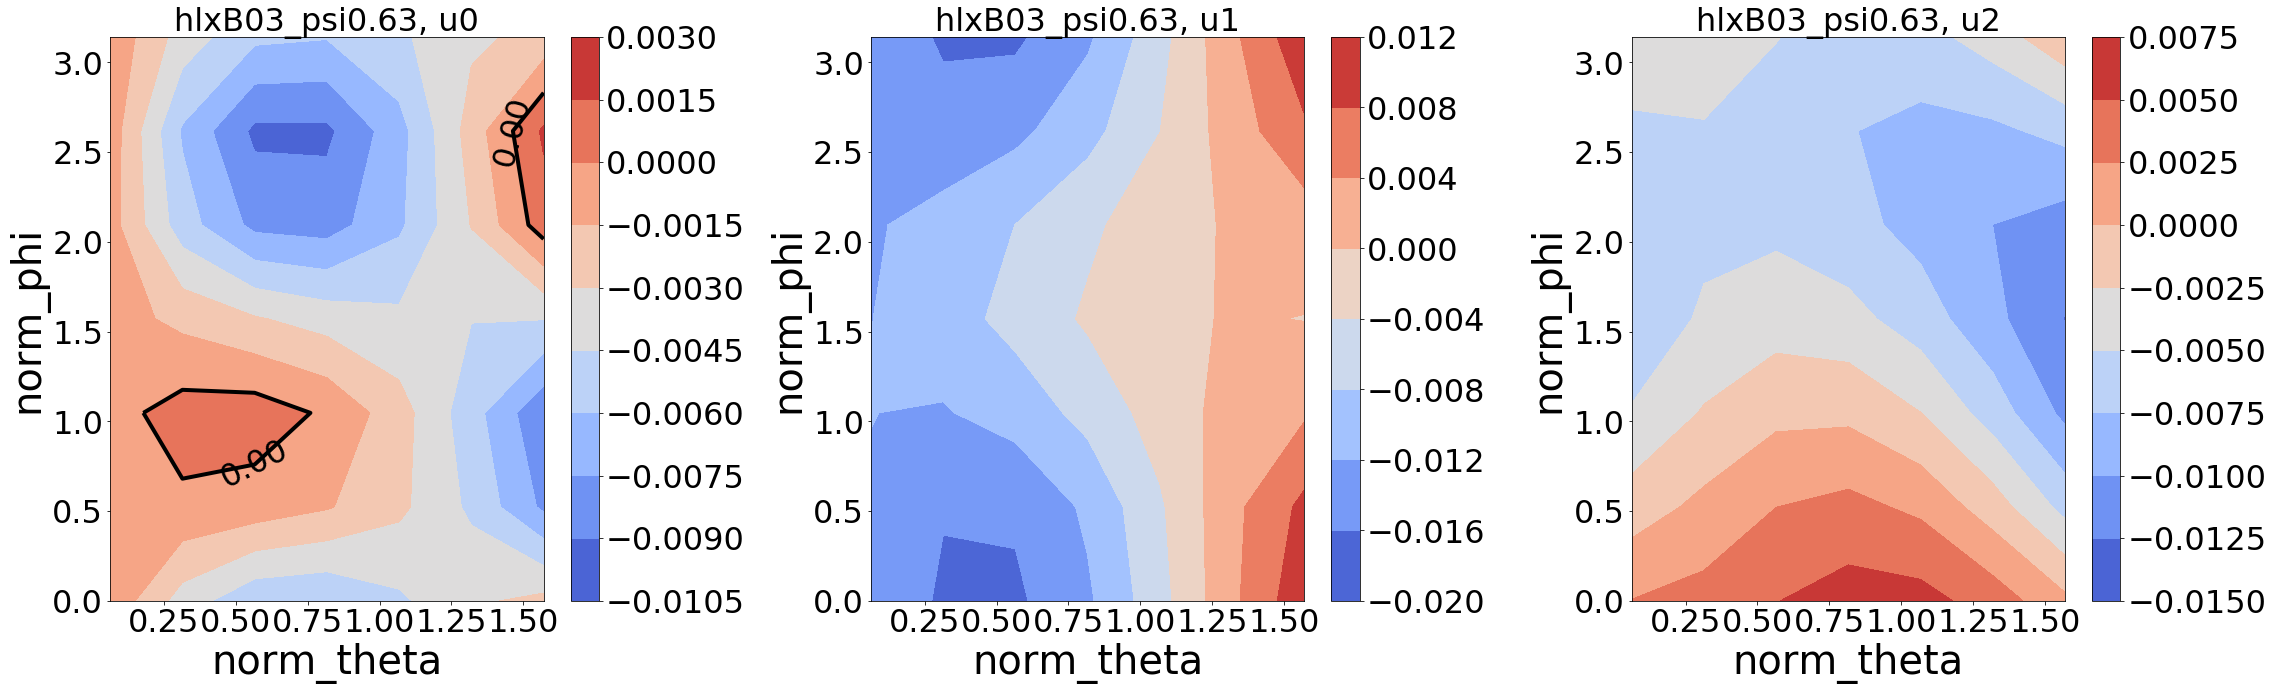

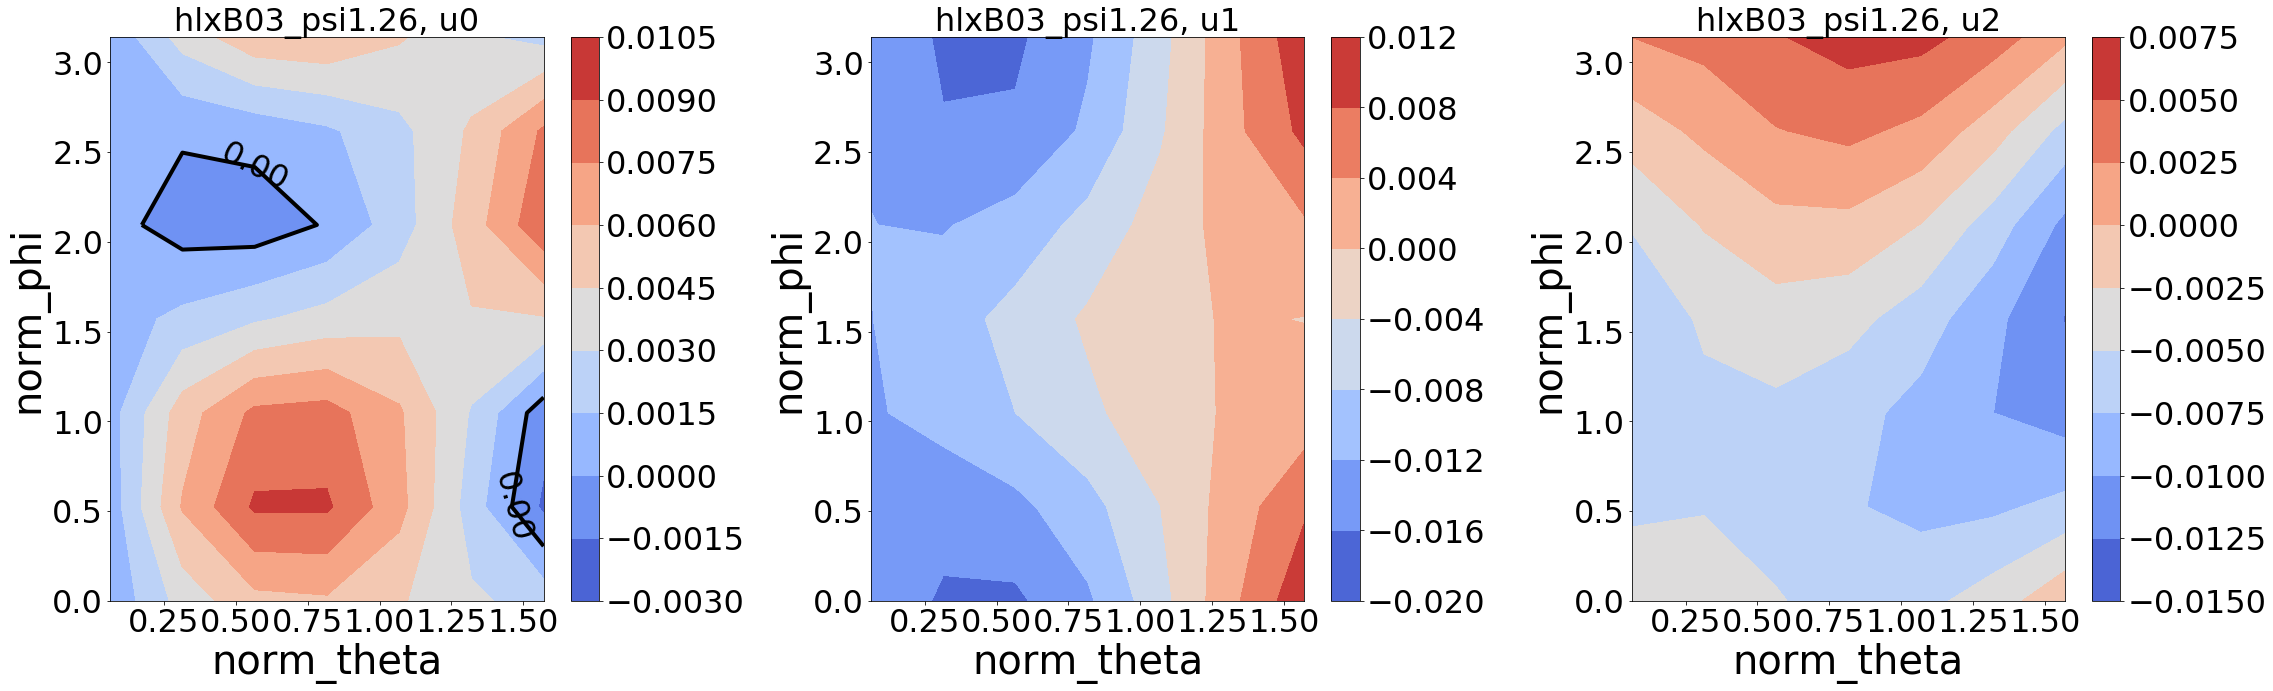

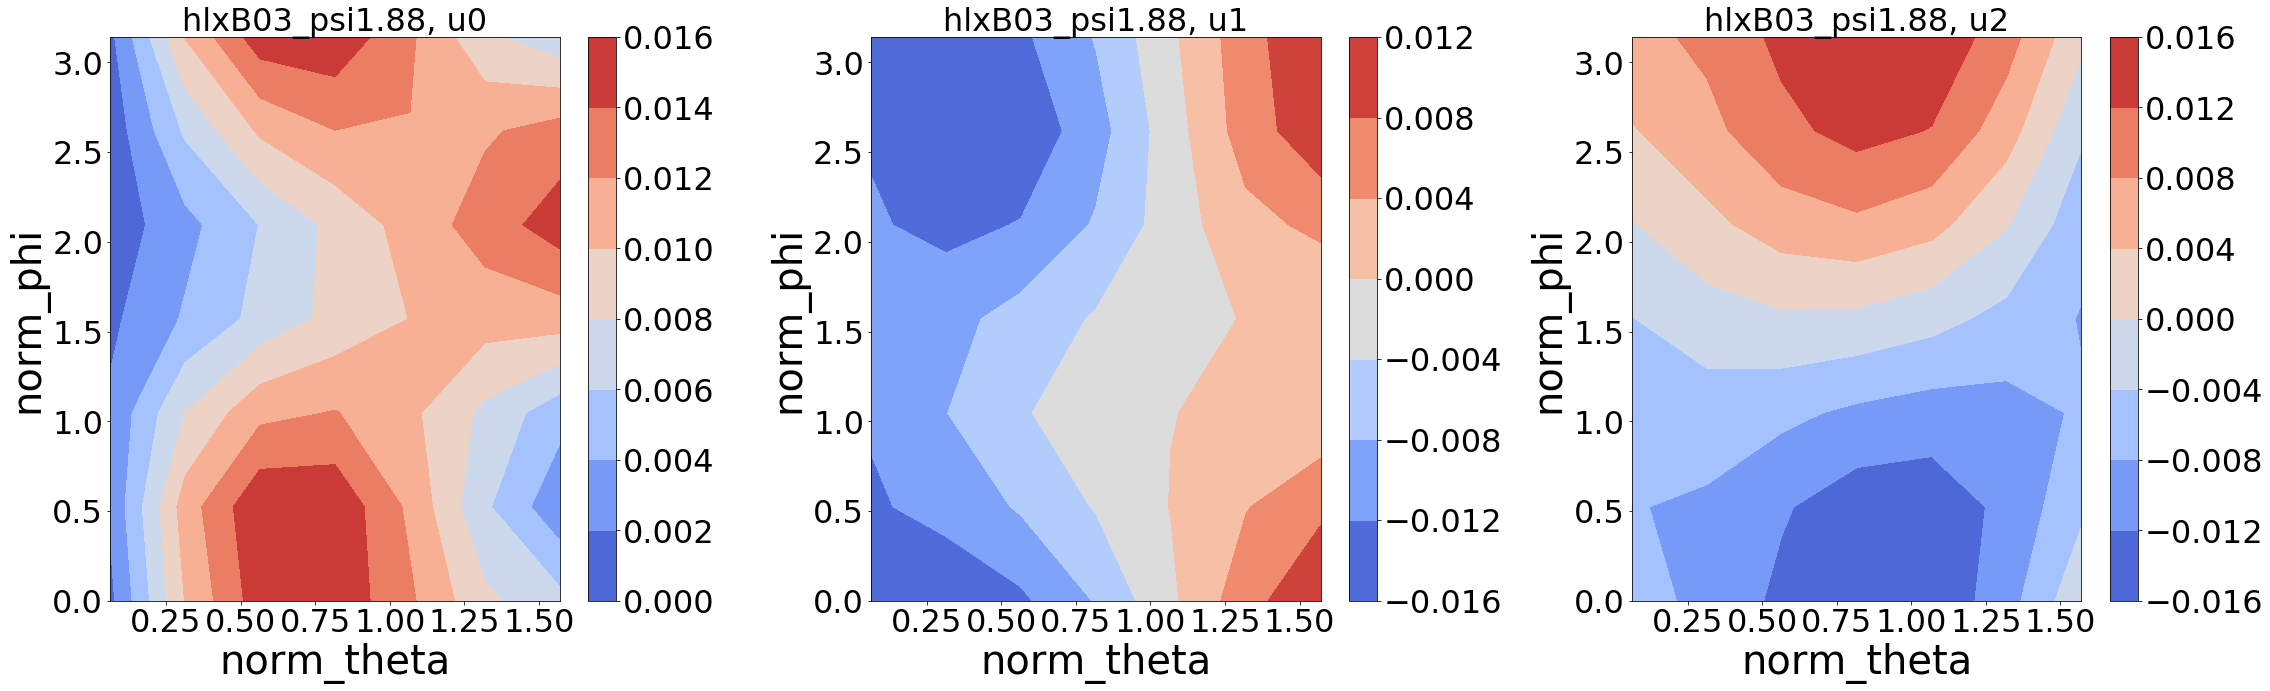

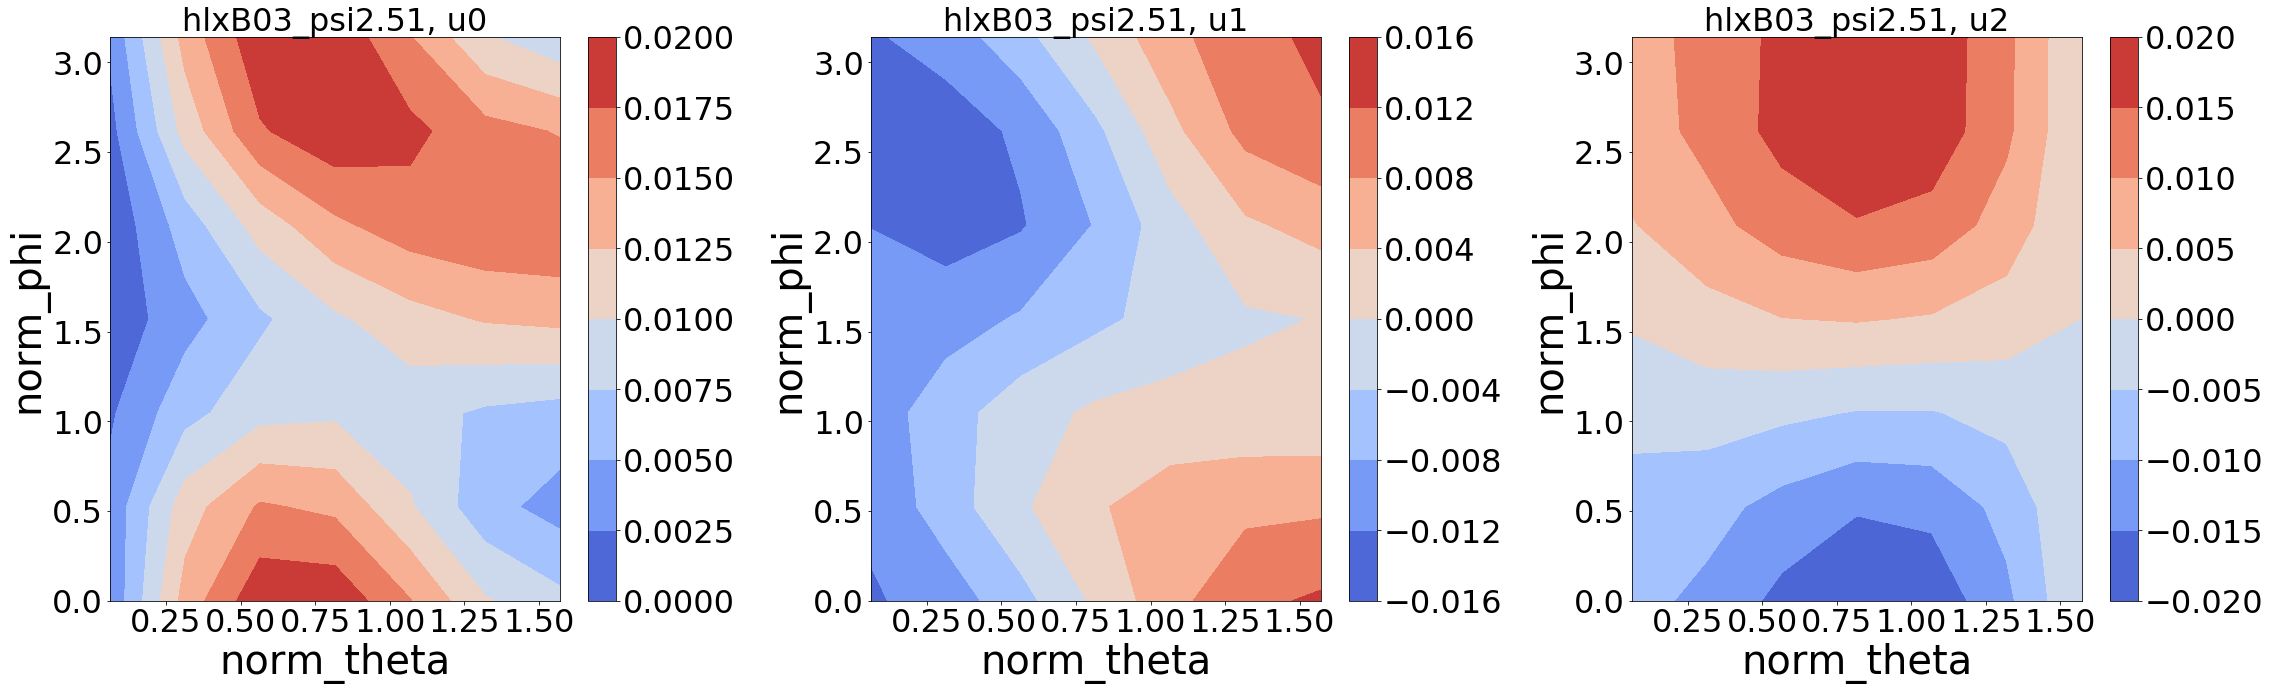

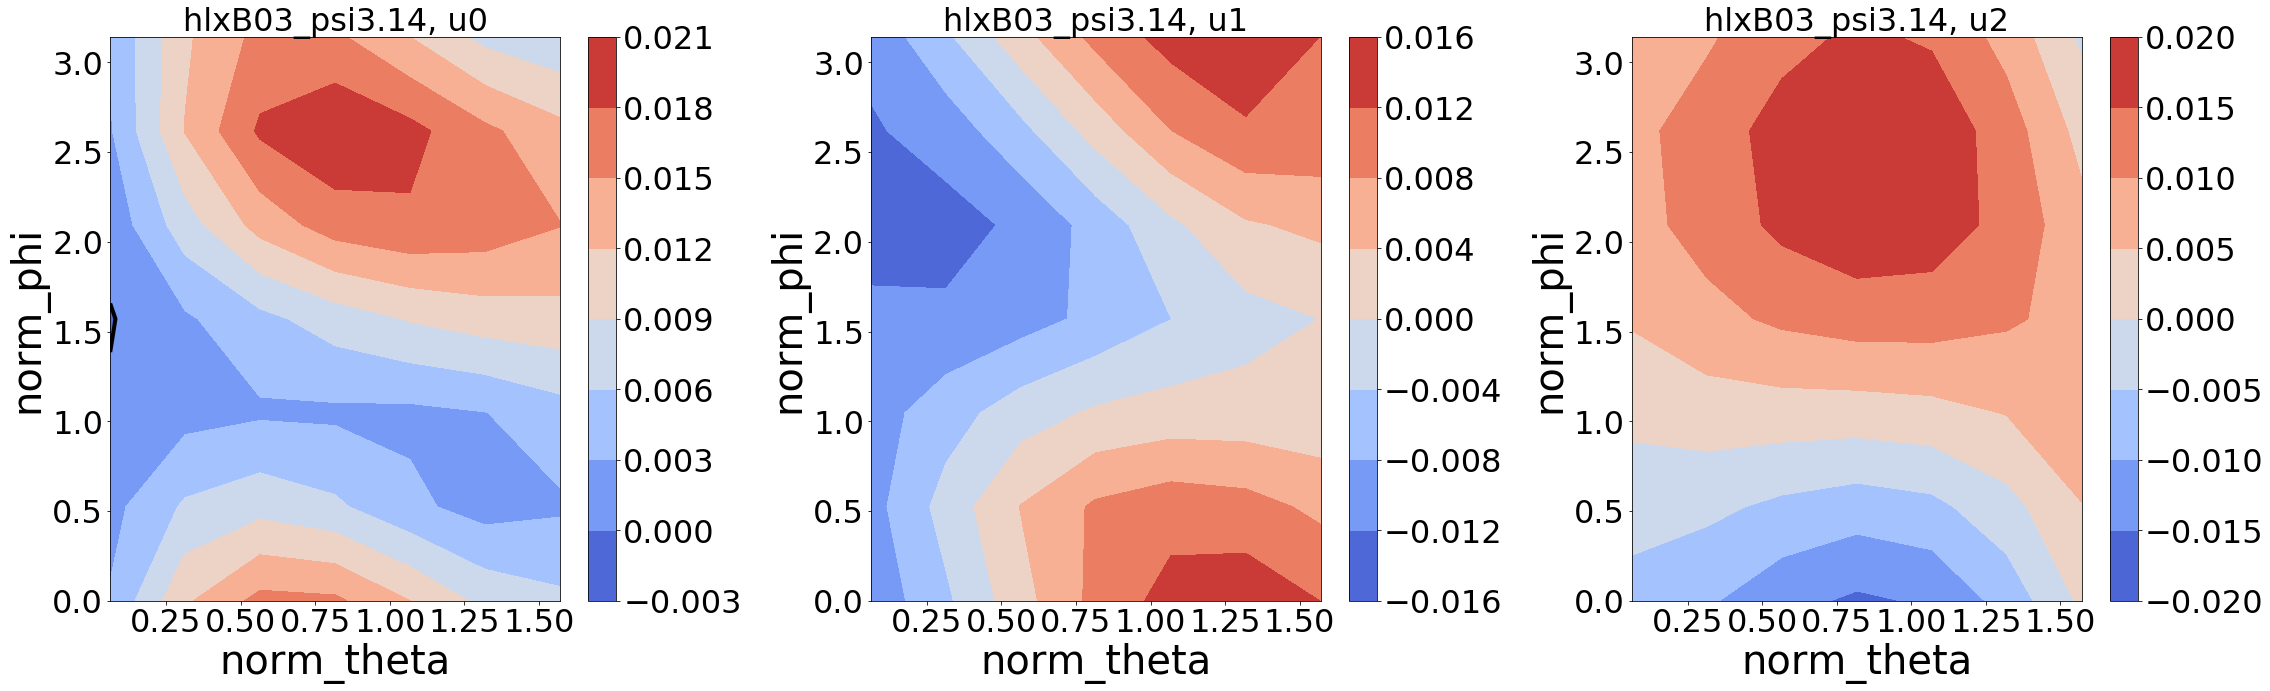

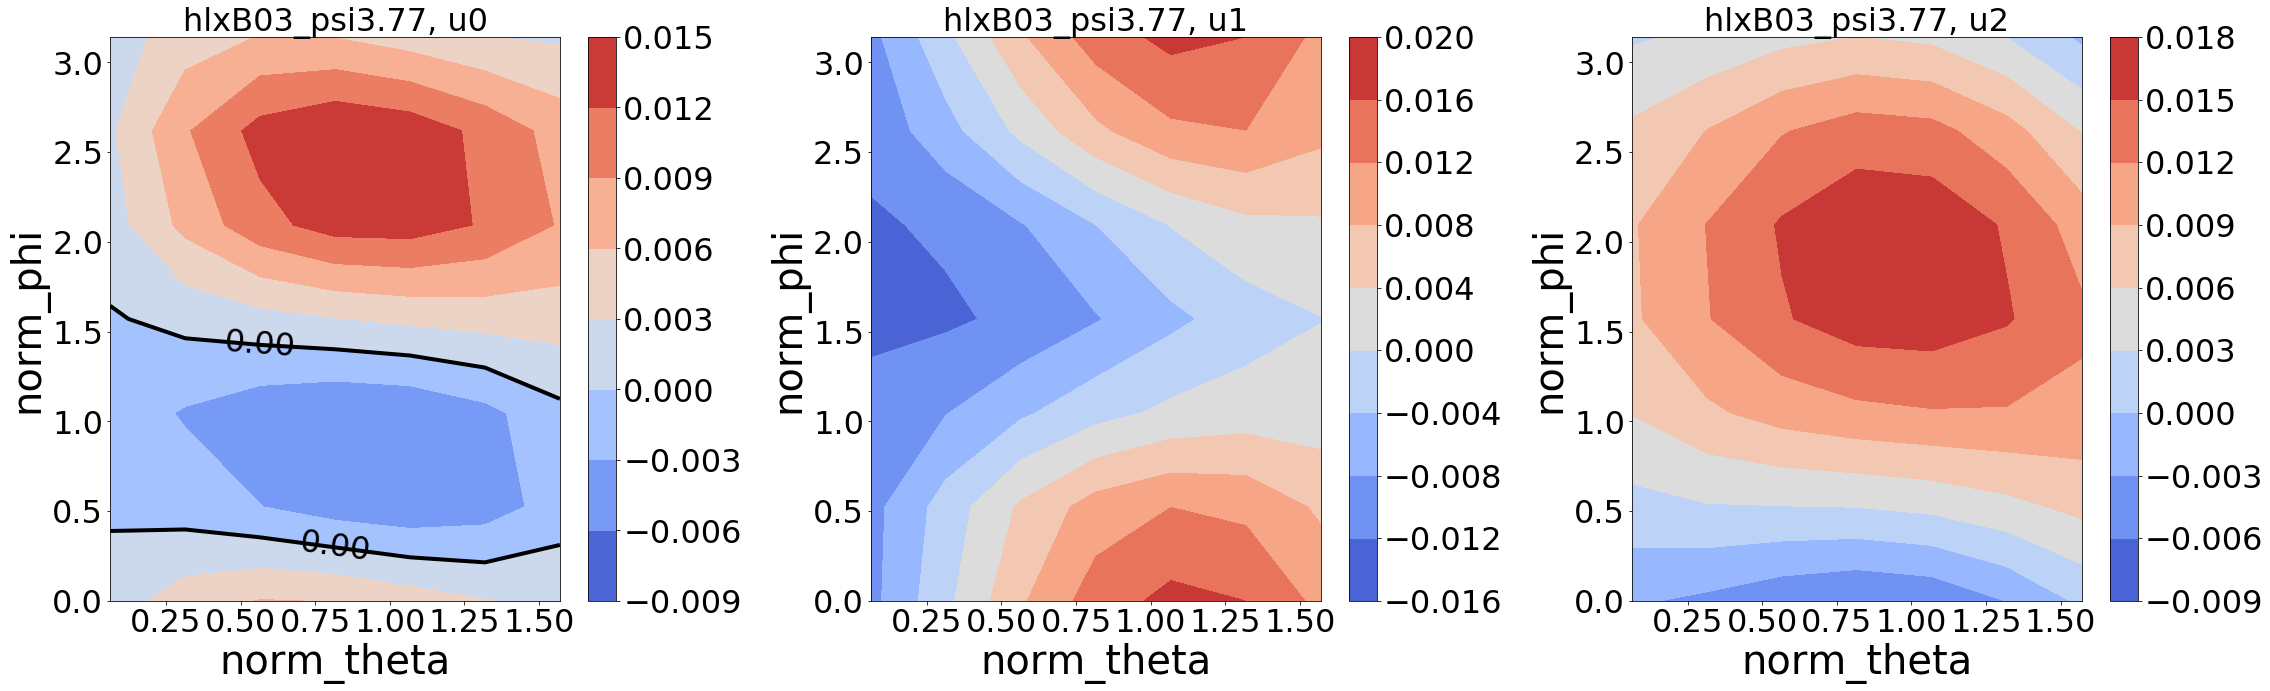

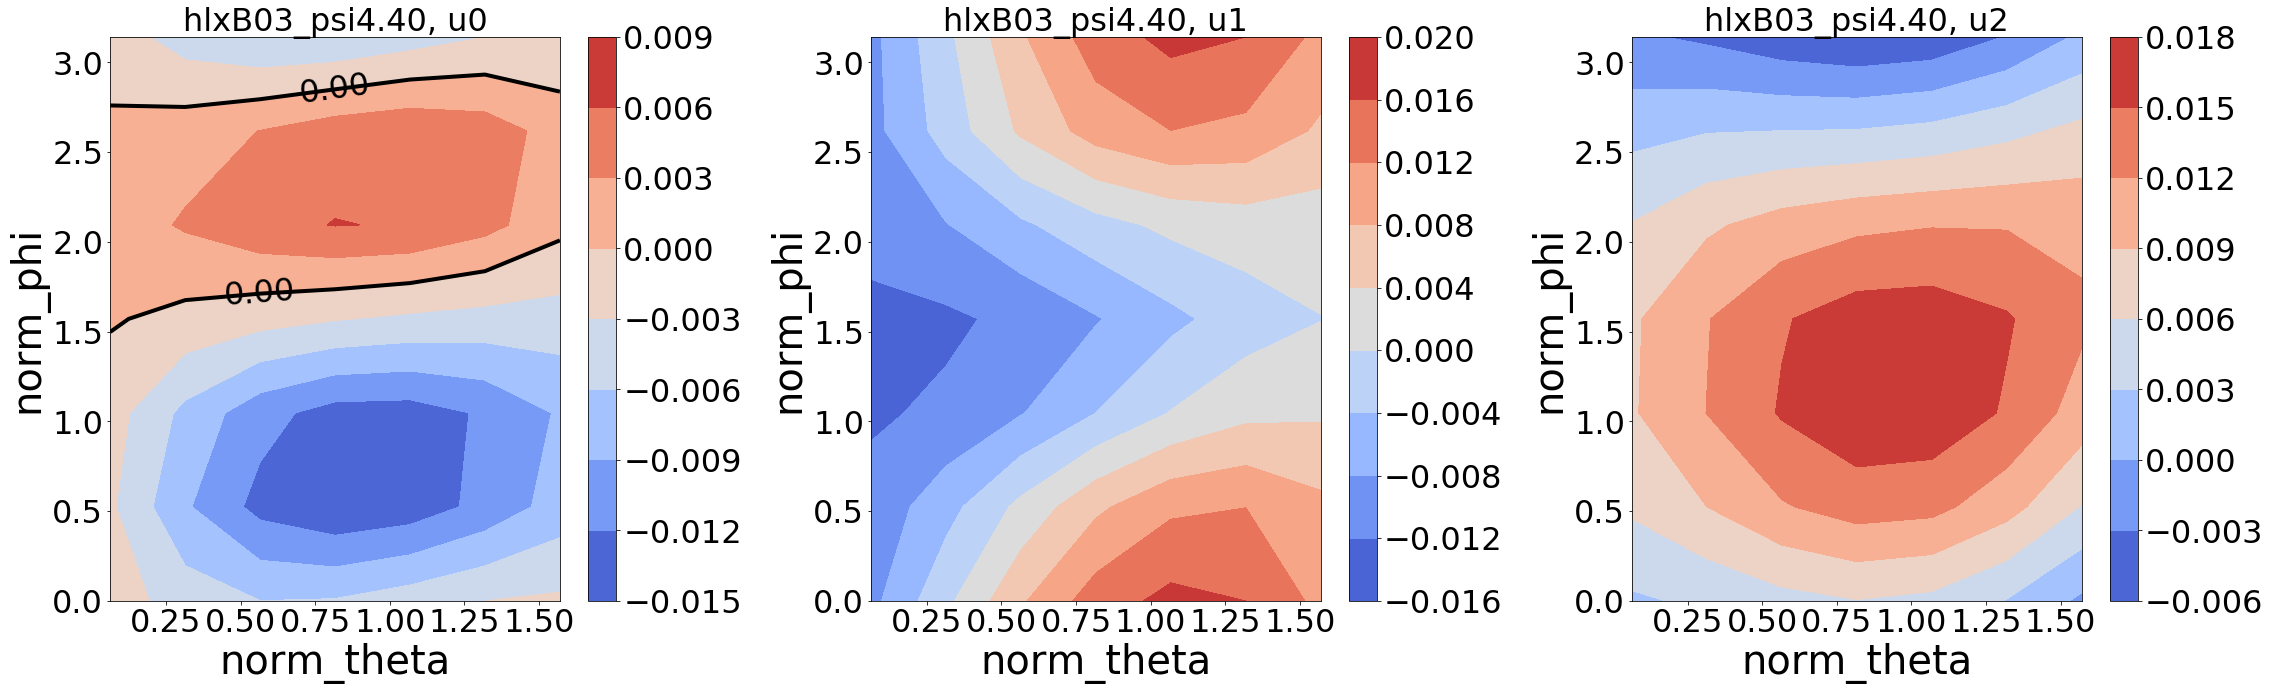

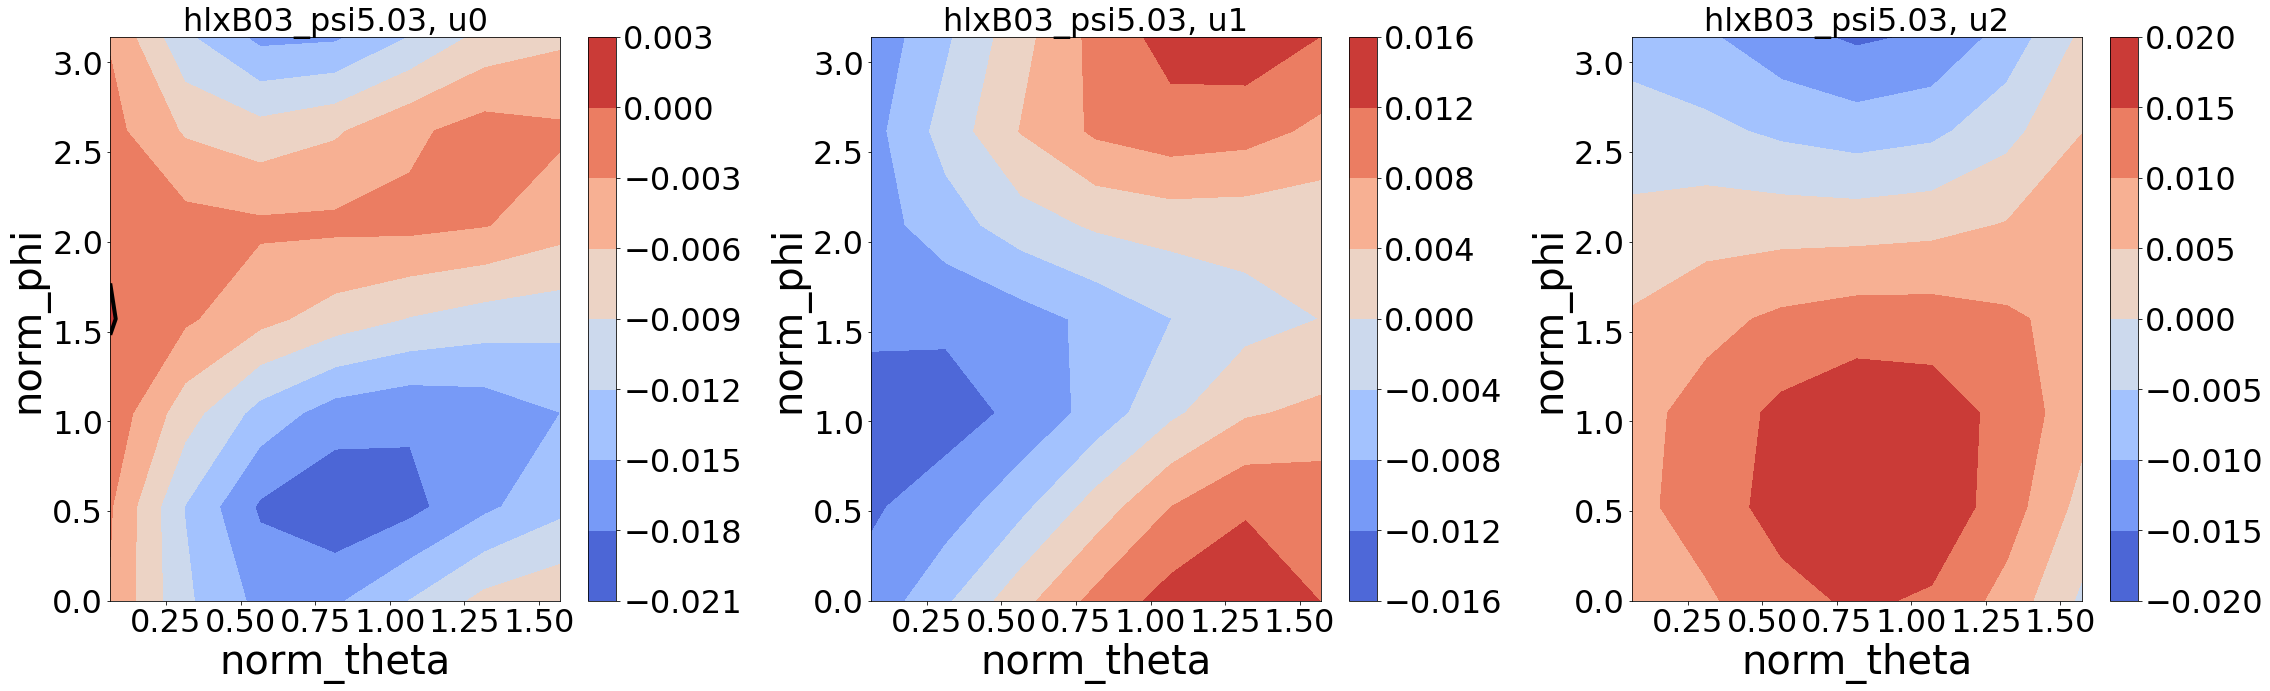

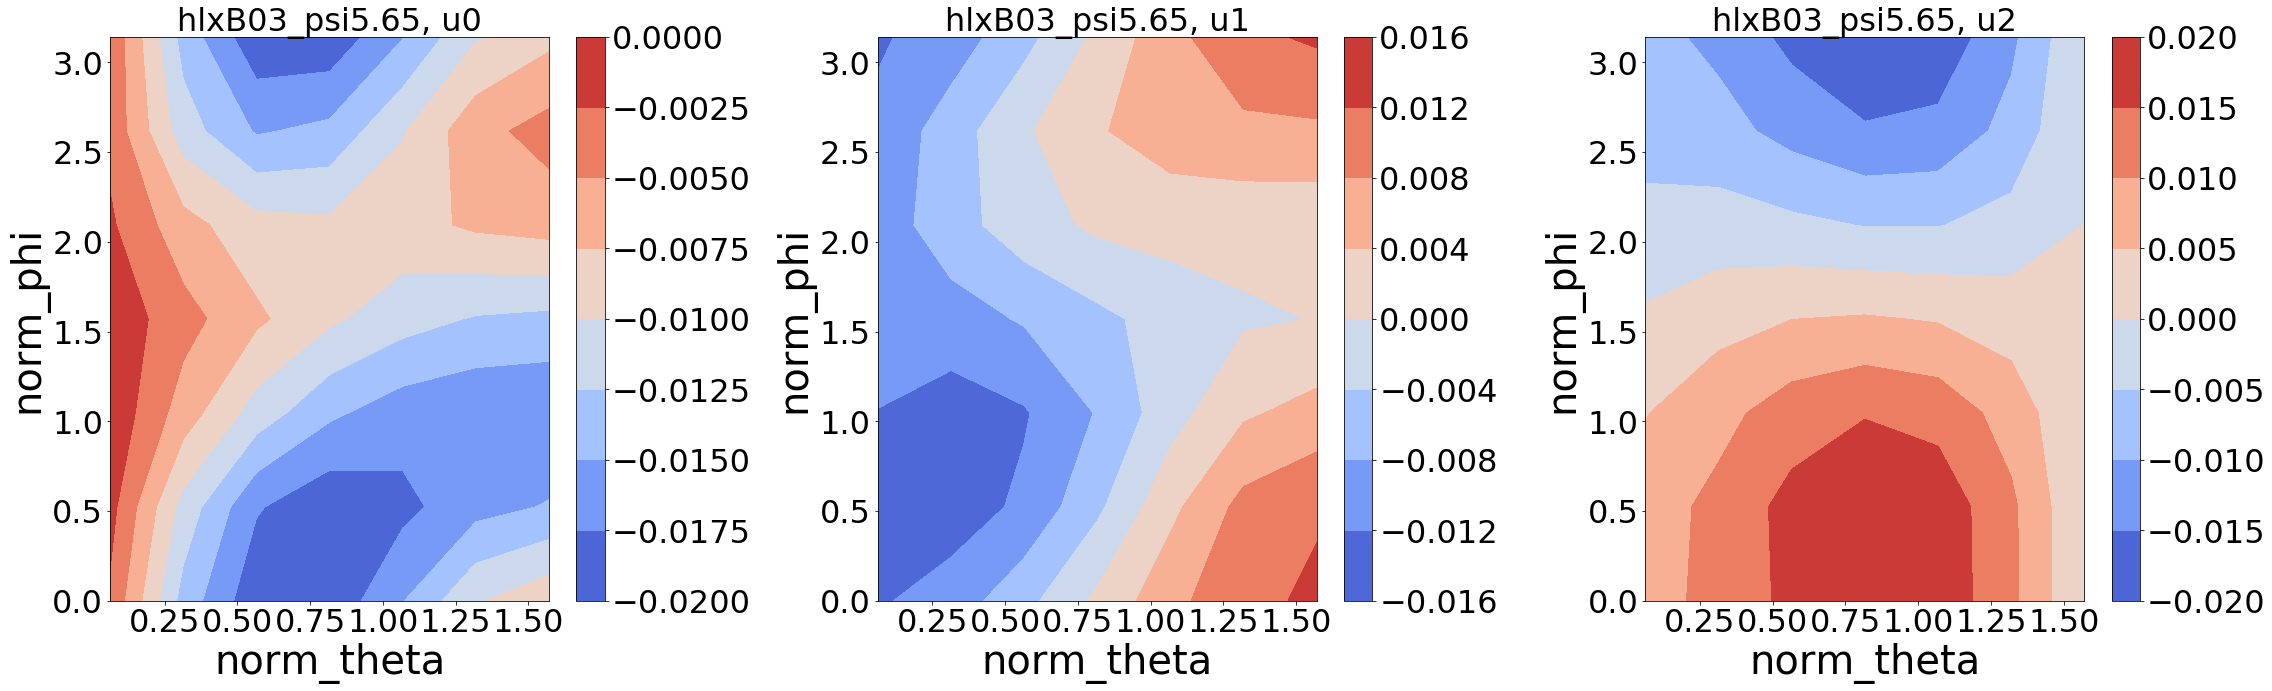

In [18]:
# %matplotlib notebook
%matplotlib inline

importlib.reload(spf)
job_dir = 'hlxB03_tau1a'
n_theat, n_phi = 25, 25
t_dir = os.path.join(PWD, job_dir)
psi_dir_list = natsort.natsorted([os.path.join(t_dir, o) for o in os.listdir(t_dir) 
                                  if os.path.isdir(os.path.join(t_dir, o))])
tcenter = np.zeros(3)

# for psi_dir in np.array(psi_dir_list)[[1, 2, 3, 4, 5, 8, 9]]:
for psi_dir in np.array(psi_dir_list):
    ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, norm_tpp, \
      ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate, file_handle \
      = read_data_psi(psi_dir, tcenter)

    fig = plt.figure(figsize=(32, 10))
    fig.patch.set_facecolor('white')
    ax0 = fig.add_subplot(1, 3, 1)
    ax1 = fig.add_subplot(1, 3, 2)
    ax2 = fig.add_subplot(1, 3, 3)
    for axi, ui, zlabeli, (vmin, vmax) in zip((ax0, ax1, ax2), 
                                                ecoli_u000[1:, :].T, 
                                                ('u0', 'u1', 'u2'), 
                                                ((-0.8, 0), (-0.3, 0.3), (-0.6, 0.6))):
        plt.sca(axi)
        ticks = np.linspace(vmin, vmax, 15)
        im = axi.contourf(norm_tpp[1:, 0].reshape((n_theat, n_phi))[::4, ::4], 
                          norm_tpp[1:, 1].reshape((n_theat, n_phi))[::4, ::4], 
                          ui.reshape((n_theat, n_phi))[::4, ::4], 
                          cmap=cm.coolwarm)
        ticks = np.linspace(vmin, vmax, 5)
        fig.colorbar(im, ax=axi).ax.tick_params(labelsize=fontsize*0.8)
        ticks = np.linspace(vmin, vmax, 10)
        im = axi.contour(norm_tpp[1:, 0].reshape((n_theat, n_phi))[::4, ::4], 
                          norm_tpp[1:, 1].reshape((n_theat, n_phi))[::4, ::4], 
                          ui.reshape((n_theat, n_phi))[::4, ::4], ticks, 
                          linewidths=fontsize*0.1, colors='k')
        plt.clabel(im, fmt='%4.2f', colors='k', fontsize=fontsize*0.8, inline=0, rightside_up=1)
#         axi.scatter(norm_tpp[1:, 0], norm_tpp[1:, 1])
#         ax0.plot(norm_tpp[:, 0], norm_tpp[:, 1], omega_jeffery[:, 1], 'o')
        axi.set_xlabel('norm_theta', size=fontsize)
        axi.set_ylabel('norm_phi', size=fontsize)
        axi.set_title('%s, %s' % (file_handle, zlabeli), size=fontsize*0.8)
        plt.xticks(fontsize=fontsize*0.8)
        plt.yticks(fontsize=fontsize*0.8)
    plt.tight_layout()

In [ ]:
importlib.reload(jm)
talpha = 3
ellipse_velocity = 0
tnorm = np.array((0, 0, 1))
lateral_norm = np.array([0, 1, 0])
rot_speed = 0

problem = jm.ShearJefferyProblem(planeShearRate=planeShearRate)
ellipse_kwargs = {'name':          file_handle,
                  'center':        tcenter,
                  'rot_speed':     rot_speed,
                  'norm':          tnorm / np.linalg.norm(tnorm),
                  'lateral_norm':  lateral_norm / np.linalg.norm(lateral_norm),
                  'speed':         ellipse_velocity,
                  'lbd':           (talpha ** 2 - 1) / (talpha ** 2 + 1)}
ellipse_obj = jm.JefferyObj(**ellipse_kwargs)
problem.add_obj(ellipse_obj)

# evaluation loop
omega_jeffery = np.zeros_like(omega_tang)
U_jeffery = np.zeros_like(omega_tang)
for i0, (xi, pi) in enumerate(zip(ecoli_center000, ecoli_norm)):
    U_jeffery[i0], dP, dP2, omega_jeffery[i0] = ellipse_obj.get_velocity_at(xi, pi, np.zeros(3), ellipse_velocity, rot_speed)
det_omega = omega_tang - omega_jeffery
det_U = ecoli_U[:, :3] - U_jeffery
det_u000 = ecoli_u000 - U_jeffery

fig = plt.figure(figsize=(32, 10))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)
for axi, omegai, zlabeli, (vmin, vmax) in zip((ax0, ax1, ax2), omega_jeffery[1:, :].T, 
                                            ('omega0', 'omega1', 'omega2'), 
                                            ((-0.06, 0.06), (0, 1), (-0.5, 0))):
    plt.sca(axi)
    ticks = np.linspace(vmin, vmax, 15)
    im = axi.contourf(norm_tpp[1:, 0].reshape((n_theat, n_phi))[::4, ::4], 
                      norm_tpp[1:, 1].reshape((n_theat, n_phi))[::4, ::4], 
                      omegai.reshape((n_theat, n_phi))[::4, ::4], ticks, 
                      cmap=cm.coolwarm)
    ticks = np.linspace(vmin, vmax, 5)
    fig.colorbar(im, ticks=ticks, ax=axi).ax.tick_params(labelsize=fontsize*0.8)
    ticks = np.linspace(vmin, vmax, 10)
    im = axi.contour(norm_tpp[1:, 0].reshape((n_theat, n_phi))[::4, ::4], 
                      norm_tpp[1:, 1].reshape((n_theat, n_phi))[::4, ::4], 
                      omegai.reshape((n_theat, n_phi))[::4, ::4], ticks, 
                      linewidths=fontsize*0.1, colors='k')
    plt.clabel(im, fmt='%4.2f', colors='k', fontsize=fontsize*0.8, inline=0, rightside_up=1)
#         axi.scatter(norm_tpp[1:, 0], norm_tpp[1:, 1])
#         ax0.plot(norm_tpp[:, 0], norm_tpp[:, 1], omega_jeffery[:, 1], 'o')
    axi.set_xlabel('norm_theta', size=fontsize)
    axi.set_ylabel('norm_phi', size=fontsize)
    axi.set_title('%s, %s' % ('Jeffery', zlabeli), size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

fig = plt.figure(figsize=(32, 10))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)
for axi, Ui, zlabeli, (vmin, vmax) in zip((ax0, ax1, ax2), U_jeffery[1:, :].T, 
                                          ('U0', 'U1', 'U2'), 
                                          ((-1, 1.5), (0, 1), (0, 1))):
    plt.sca(axi)
    ticks = np.linspace(vmin, vmax, 15)
    im = axi.contourf(norm_tpp[1:, 0].reshape((n_theat, n_phi))[::4, ::4], 
                      norm_tpp[1:, 1].reshape((n_theat, n_phi))[::4, ::4], 
                      Ui.reshape((n_theat, n_phi))[::4, ::4], ticks, 
                      cmap=cm.coolwarm)
    ticks = np.linspace(vmin, vmax, 5)
    fig.colorbar(im, ticks=ticks, ax=axi).ax.tick_params(labelsize=fontsize*0.8)
    ticks = np.linspace(vmin, vmax, 10)
    im = axi.contour(norm_tpp[1:, 0].reshape((n_theat, n_phi))[::4, ::4], 
                      norm_tpp[1:, 1].reshape((n_theat, n_phi))[::4, ::4], 
                      Ui.reshape((n_theat, n_phi))[::4, ::4], ticks, 
                      linewidths=fontsize*0.1, colors='k')
    plt.clabel(im, fmt='%4.2f', colors='k', fontsize=fontsize*0.8, inline=0, rightside_up=1)
#         axi.scatter(norm_tpp[1:, 0], norm_tpp[1:, 1])
#         ax0.plot(norm_tpp[:, 0], norm_tpp[:, 1], omega_jeffery[:, 1], 'o')
    axi.set_xlabel('norm_theta', size=fontsize)
    axi.set_ylabel('norm_phi', size=fontsize)
    axi.set_title('%s, %s' % ('Jeffery', zlabeli), size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


In [293]:
importlib.reload(spf)
job_dir = 'planeShearRatex_1a'
n_theat, n_phi = 25, 25
t_dir = os.path.join(PWD, job_dir)
psi_dir_list = natsort.natsorted([os.path.join(t_dir, o) for o in os.listdir(t_dir) 
                                  if os.path.isdir(os.path.join(t_dir, o))])
myformat = ('%f ' * 6)[:-1]
terr_list_all = []
for psi_dir in psi_dir_list:
    txt_name = os.path.basename(psi_dir)
    filename = os.path.join(psi_dir, txt_name+'.txt')
    with open(filename, 'r') as myinput:
        FILE_DATA = myinput.read()
    t_match_iter = re.finditer('ini ref_U1 in shear flow \[', FILE_DATA)
    ref_U1_list = []
    for t_match in t_match_iter:
        ref_U1_list.append(np.array(scanf(myformat, FILE_DATA[t_match.end():])))
    ref_U1 = np.vstack(ref_U1_list)
    t_match_iter = re.finditer('true ref_U in shear flow \[', FILE_DATA)
    ref_Ut_list = []
    for t_match in t_match_iter:
        ref_Ut_list.append(np.array(scanf(myformat, FILE_DATA[t_match.end():])))
    ref_U1 = np.vstack(ref_U1_list)
    ref_Ut = np.vstack(ref_Ut_list)
    tU = np.linalg.norm(ref_Ut[:, :3], axis=1)
    tW = np.linalg.norm(ref_Ut[:, 3:], axis=1)
    terr_list_all.append(np.abs((ref_U1 - ref_Ut) / np.vstack([tU, tU, tU, tW, tW, tW]).T))
print([t1.max() for t1 in terr_list_all])

[0.0029492791036293434, 0.0029662017339323788, 0.0030779453682660044, 0.0030267085286273488, 0.0030670026088308322, 0.0025135108475648872, 0.0034601586665790199, 0.0037771831733085545, 0.0030472203692087797, 0.0032999840501832666]


In [31]:
def read_data_loopup_table(psi_dir_list, tcenter, ignore_first=0):
    ecoli_U_list = []
    ecoli_norm_list = []
    ecoli_center_list = []
    ecoli_nodes_list = []
    ecoli_lateral_norm_list = []
    ecoli_idx_list = []
    norm_phi_list = []
    norm_psi_list = []
    norm_theta_list = []
    i0 = -1
    for psi_dir in psi_dir_list:
        file_handle = os.path.basename(psi_dir)
        mat_names = natsort.natsorted(glob.glob('%s/%s_*.mat' % (psi_dir, file_handle)))
        for mati in mat_names[ignore_first:]:
            i0 = i0 + 1
            mat_contents = loadmat(mati)
            ecoli_U = mat_contents['ecoli_U'].flatten()
            ecoli_norm = mat_contents['ecoli_norm'].flatten()
            ecoli_center = mat_contents['ecoli_center'].flatten()
            planeShearRate = mat_contents['planeShearRate'].flatten()
            ecoli_nodes = mat_contents['ecoli_nodes']
            norm_phi = mat_contents['norm_phi'].flatten()
            norm_psi = mat_contents['norm_psi'].flatten()
            norm_theta = mat_contents['norm_theta'].flatten()
            ecoli_U_list.append(ecoli_U)
            ecoli_norm_list.append(ecoli_norm)
            ecoli_center_list.append(ecoli_center)
            ecoli_idx_list.append(i0)
            norm_phi_list.append(norm_phi)
            norm_psi_list.append(norm_psi)
            norm_theta_list.append(norm_theta)
            r0 = ecoli_nodes[-1] - ecoli_center
            n0 = np.dot(r0, ecoli_norm) * ecoli_norm / np.dot(ecoli_norm, ecoli_norm)
            t0 = r0 - n0
            ecoli_lateral_norm_list.append(t0 / np.linalg.norm(t0))

    ecoli_U = np.vstack(ecoli_U_list)
    ecoli_norm = np.vstack(ecoli_norm_list)
    ecoli_center = np.vstack(ecoli_center_list)
    ecoli_lateral_norm = np.vstack(ecoli_lateral_norm_list)
    ecoli_idx = np.hstack(ecoli_idx_list)
    norm_phi = np.hstack(norm_phi_list)
    norm_psi = np.hstack(norm_psi_list)
    norm_theta = np.hstack(norm_theta_list)
    norm_tpp = np.vstack((norm_theta, norm_phi, norm_psi)).T

    # calculate velocity u000(t,x,y,z) that the location initially at (0, 0, 0): u000(0, 0, 0, 0)
    n_u000 = -np.linalg.norm(ecoli_center[0] - tcenter) * ecoli_norm
    ecoli_u000 = ecoli_U[:, :3] + np.cross(ecoli_U[:, 3:], n_u000)
    # calculate center center000(t,x,y,z) that at initially at (0, 0, 0): center000(0, 0, 0, 0)
    ecoli_center000 = ecoli_center + n_u000
    using_U = ecoli_U
    omega_norm = np.array([np.dot(t1, t2)*t2/np.dot(t2, t2) for t1, t2 in zip(using_U[:, 3:], ecoli_norm)])
    omega_tang = using_U[:, 3:] - omega_norm
    
    return ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, ecoli_idx, norm_tpp, \
           ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate

In [32]:
importlib.reload(spf)
job_dir = 'hlxB01_tau1a'
# psi_dir = '/home/zhangji/stokes_flow_master/head_Force/loop_table/hlxB01_tau1a/hlxB01_psi0.00'
t_dir = os.path.join(PWD, job_dir)
psi_dir_list = natsort.natsorted([os.path.join(t_dir, o) for o in os.listdir(t_dir) 
                                  if os.path.isdir(os.path.join(t_dir, o))])

ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, ecoli_idx, norm_tpp, \
  ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate \
  = read_data_loopup_table(psi_dir_list=psi_dir_list, tcenter=tcenter, ignore_first=0)

norm_theta = norm_tpp[:, 0]
norm_phi = norm_tpp[:, 1]
norm_psi = norm_tpp[:, 2]
data = pd.DataFrame({'norm_theta': norm_theta, 
                    'norm_phi': norm_phi, 
                    'norm_psi': norm_psi, 
                    'ecoli_U0': ecoli_U[:, 0], 
                    'ecoli_U1': ecoli_U[:, 1], 
                    'ecoli_U2': ecoli_U[:, 2], 
                    'ecoli_U3': ecoli_U[:, 3], 
                    'ecoli_U4': ecoli_U[:, 4], 
                    'ecoli_U5': ecoli_U[:, 5], 
                    }).pivot_table(index=['norm_theta', 'norm_phi', 'norm_psi'])
ecoli_U0 = data.ecoli_U0.unstack()
ecoli_U1 = data.ecoli_U1.unstack()
ecoli_U2 = data.ecoli_U2.unstack()
ecoli_U3 = data.ecoli_U3.unstack()
ecoli_U4 = data.ecoli_U4.unstack()
ecoli_U5 = data.ecoli_U5.unstack()
use_theta_list = data.index.levels[0].values
use_phi_list = data.index.levels[1].values
use_psi_list = data.index.levels[2].values


(0, 1)

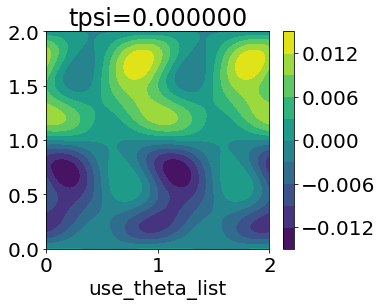

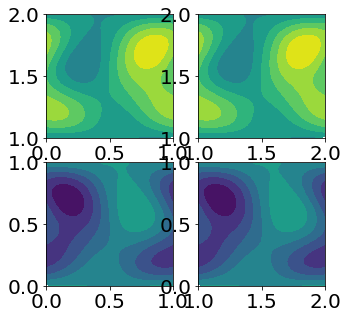

In [145]:
for tpsi in use_psi_list[[0]]:
    use_U = ecoli_U0[tpsi].unstack().interpolate(method='quadratic',axis=1).interpolate(method='quadratic',axis=0)
    fig = plt.figure(figsize=(5, 4))
    fig.patch.set_facecolor('white')
    ax0 = fig.add_subplot(1, 1, 1)
    im = ax0.contourf(use_phi_list / np.pi, use_theta_list / np.pi, use_U, 10)
    ax0.set_title('tpsi=%f' % tpsi)
    ax0.set_xlabel('use_phi_list')
    ax0.set_xlabel('use_theta_list')
    fig.colorbar(im)
    levels = im.levels

tU = ecoli_U0[tpsi].unstack()
tx = tU.columns.values
ty = tU.index.values
idx = ~np.ma.masked_invalid(tU.values).mask
txx, tyy = np.meshgrid(tx, ty)
tU1 = tU.values[idx]
tx1 = txx[idx]
ty1 = tyy[idx]
use_U = interpolate.griddata((tx1, ty1), tU1.ravel(), (txx, tyy), method='cubic')
tmp_theta = use_theta_list[use_theta_list <= np.pi]
tmp_phi = use_phi_list[use_phi_list <= np.pi]
tmp_U = use_U[use_theta_list <= np.pi].T[use_phi_list <= np.pi].T
fig = plt.figure(figsize=(5, 5))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)
ax0.contourf((1 - tmp_phi / np.pi), tmp_theta / np.pi + 1, -tmp_U, levels)
ax0.set_xlim(0, 1)
ax0.set_ylim(1, 2)
ax1.contourf((2 - tmp_phi / np.pi), tmp_theta / np.pi + 1, -tmp_U, levels)
ax1.set_xlim(1, 2)
ax1.set_ylim(1, 2)
ax2.contourf(tmp_phi / np.pi, tmp_theta / np.pi, tmp_U, levels)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax3.contourf(tmp_phi / np.pi + 1, tmp_theta / np.pi, tmp_U, levels)
ax3.set_xlim(1, 2)
ax3.set_ylim(0, 1)

def intp_U(tmp_theta, tmp_phi, tmp_U)

array([[     nan,  0.00026,  0.00027, ...,  0.0002 ,  0.00022,  0.00025],
       [-0.00105, -0.00097, -0.00094, ..., -0.00118, -0.00112, -0.00105],
       [-0.00165, -0.00154, -0.00151, ..., -0.00181, -0.00174, -0.00165],
       ..., 
       [ 0.00394,  0.00374,  0.00366, ...,  0.0042 ,  0.0041 ,  0.00394],
       [ 0.00213,  0.00204,  0.002  , ...,  0.00223,  0.00219,  0.00213],
       [ 0.00025,  0.00026,  0.00026, ...,  0.0002 ,  0.00022,  0.00025]])